In [204]:
import matplotlib.pyplot as plt
import numpy as np
import time
import random

%matplotlib notebook

## 1) MC Integration ##

In [277]:
I_exact = -2*(5**(-1/2)-1)
print(I_exact)

nums = []
numsSq = []
for n in range(100000):
    num = random.uniform(1, 5)
    val = num**(-3/2)
    nums.append(val)
    numsSq.append(val**2)
    
funcAvg = np.mean(nums)
func2Avg = np.mean(numsSq)
Integral = (5-1)*funcAvg
stdDev = (5-1)*np.sqrt((func2Avg -(funcAvg)**2)/100000)
print(Integral)
print(stdDev)

1.1055728090000843
1.1053881959240914
0.002638511428033612


I like this process becuase it makes sense to me and the calculation of the standard deviation seems straight forward. However, part of me still feels like there is bias in the random number generation and it seems like some areas would be overcounted. However, it seems much easier to increase the number of samples here compared to changing the step size for the initegration methods we've used previously. 

## 2) A random stroll from the center of the Sun ##

In [179]:
def gen_ran_theta(seed):
    a = 1664525
    c = 1013904223
    #m = 4294967296
    m = 2*np.pi
    theta = (a*seed+c)%m
    return theta

def stroll(radius, N):
    particles = N
    sunRadius = radius #cm
    theta_seed = np.linspace(0, 2*np.pi, num = particles)
    times = []
    for n in range(particles):
        thetas = [theta_seed[n]]
        r = 0
        i = 0
        timeEsc = 0
         
        while np.abs(r)<sunRadius:
            scat_ang = gen_ran_theta(thetas[i])

            dr = mfp*np.sin(scat_ang)
            r+=dr
            thetas.append(scat_ang)

            timeEsc += t_step
            i += 1
        times.append(timeEsc)
    return np.mean(times)

mfp = .4 # cm
speed = 2.998e10 #cm/s
t_step = mfp/speed

tic1 = time.perf_counter()
t_7 = stroll(7, 100)
toc1 = time.perf_counter()
run_time1 = toc1-tic1

print('Escape time: ', t_7, ', Computing Time: ', run_time1)

tic2 = time.perf_counter()
t_70 = stroll(70, 100)
toc2 = time.perf_counter()
run_time2 = toc2-tic2

print('Escape time: ', t_70, ', Computing Time: ', run_time2)


Escape time:  8.290860573715763e-09 , Computing Time:  0.2793528980000701
Escape time:  8.208329553031792e-07 , Computing Time:  26.193427428001087


<IPython.core.display.Javascript object>


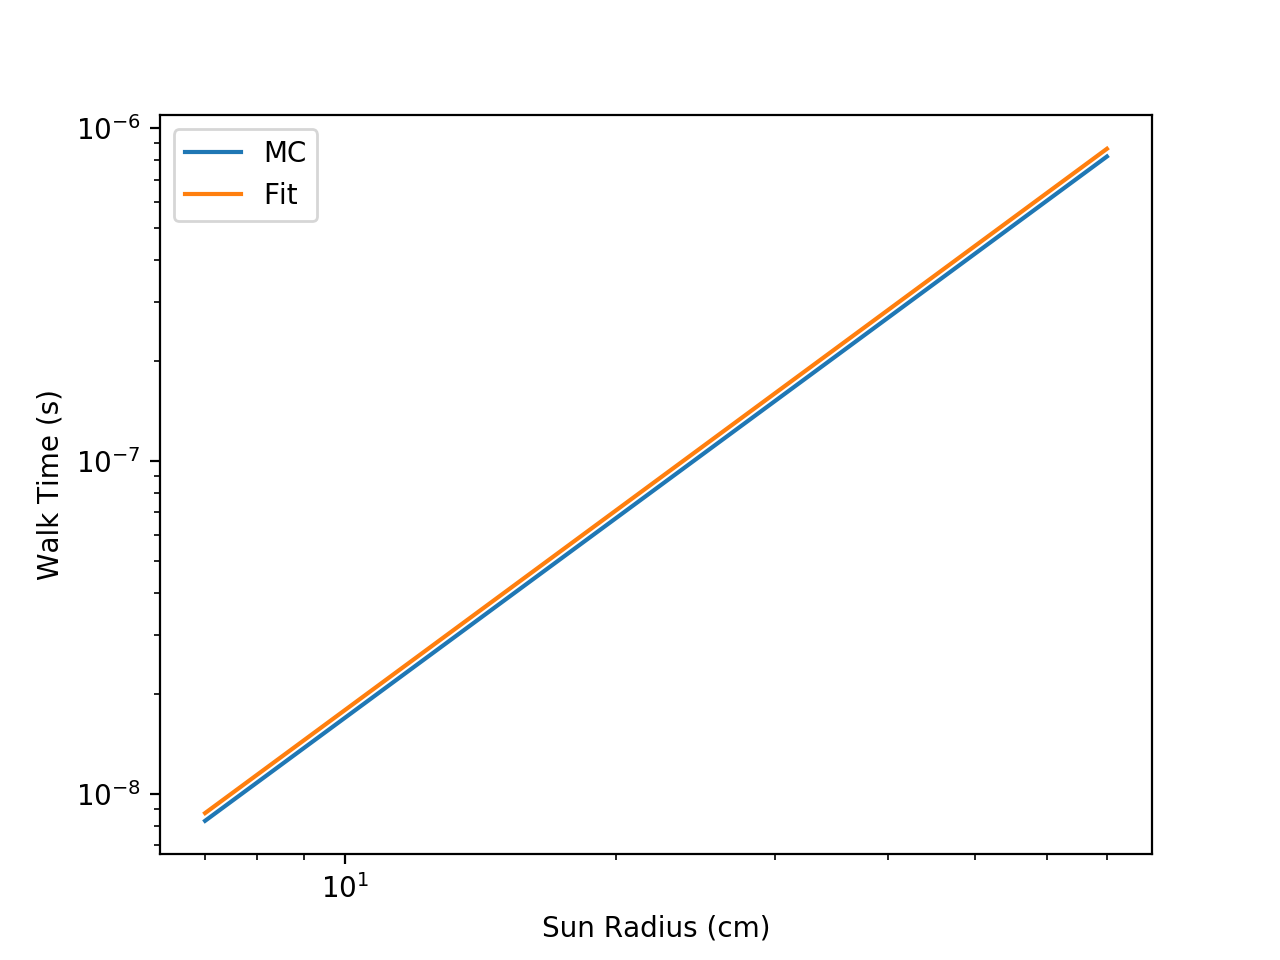

Real Stroll Time Estimate:  24790.0  years


In [194]:
# after creating a log-log plot I realized the change appeared to follow a power law
# after finding the power of the relationship I guessed the scaling factor until it seemed to match up

radii = [7, 70]
times = [t_7, t_70]
power = (np.log(times[-1])-np.log(times[0]))/(np.log(radii[-1])-np.log(radii[0]))

time_ex = [1.8e-10*radius**power for radius in radii]
plt.figure()
plt.loglog(radii, times, label = 'MC')
plt.loglog(radii, time_ex, label = 'Fit')
plt.xlabel('Sun Radius (cm)')
plt.ylabel('Walk Time (s)')
plt.legend()

realRad = 6.957e+10 #cm
RealTime = 1.8e-10*realRad**power/(60*60*24*365)

print('Real Stroll Time Estimate: ', round(RealTime/10)*10, ' years')

### Lessons Lerned ###

Due to its high probability of scattering, it take thousands of years for a photon to escape from the sun! From timing how long it takes the code to run, I see a dramatic increase in time just between changing the test radius by an order of magnitude. I also did a lot of work (not shown anymore) trying to include more data points at higher radii values but the computational time to do this for mulitple particles was too long for my impatient work style. 

## 3) Observing Dusty Protostars ##

### Part a: Hyperion Random Numbers ###

Looking through the hyperion code I first found that random numbers are used for mc_linear_polarization() function and mc_circular_polarization(). Both of these cases use a numpy function to sample an array of initial points from a normal distribution centerd at 0 with a standard deviation of 1. I also found an example script that generated random sources by drawing from a uniform distribution ranging from -10 to 10 pc. 

### Part b: Analytical YSO Models ###

In [184]:
from hyperion.model import AnalyticalYSOModel
from hyperion.util.constants import rsun, lsun, au, msun, yr, c

# Initalize the model
m = AnalyticalYSOModel()


# Set the stellar parameters
m.star.radius = 2 * rsun
m.star.luminosity = 5*lsun
m.star.temperature = 6200

# Add a flared disk
disk = m.add_flared_disk()
disk.mass = 0.01 * msun
disk.rmin = 10 * rsun
disk.rmax = 200 * au
disk.r_0 = m.star.radius
disk.h_0 = 0.01 * disk.r_0 
disk.p = -1.0
disk.beta = 1.25
disk.dust = 'kmh_lite.hdf5'

# Add a power law envelope
envelope = m.add_power_law_envelope()
envelope.mass = 0.4 * msun
envelope.r_0 = disk.rmax
envelope.rmin = 200 * rsun
envelope.rmax = 1e4 * au
envelope.power = -2
envelope.dust = 'kmh_lite.hdf5'

# Use raytracing to improve s/n of thermal/source emission
m.set_raytracing(True)

# Use the modified random walk
m.set_mrw(True, gamma=2.)

# Set up grid
m.set_spherical_polar_grid_auto(200, 100, 5)

# Set up SED
sed = m.add_peeled_images(sed=True, image=False)
sed.set_viewing_angles(np.linspace(0., 90., 10), np.repeat(45., 10))
sed.set_wavelength_range(150, 0.02, 2000.)

# Set number of photons
m.set_n_photons(initial=10000, imaging=10000,
                raytracing_sources=10000, raytracing_dust=10000)

# Set number of temperature iterations and convergence criterion
#m.set_n_initial_iterations(10)
#m.set_convergence(True, percentile=99.0, absolute=2.0, relative=1.1)

# Write out file
m.write('class1_example.rtin')
m.run('class1_example.rtout', mpi=True)

INFO: Disk density is being re-scaled by a factor of 0.93 to give the correct mass. [hyperion.densities.flared_disk]
INFO: Normalization factor for envelope mass:  0.99 [hyperion.densities.power_law_envelope]
INFO: Merging densities (identical hashes) [hyperion.model.model]


SystemExit: An error occurred, and the run did not complete

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [185]:
%tb

SystemExit: An error occurred, and the run did not complete

I don't know what this error could be. I tried looking at the source code to describe this but couldn't really find anything helpful. I continue the process as if this part worked but will not be able to show my real results.

In [36]:
from hyperion.model import ModelOutput
from hyperion.util.constants import pc

m = ModelOutput('class2_sed.rtout')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Extract all SEDs
sed = m.get_sed(inclination='all', aperture=-1, distance=300 * pc)

# Plot SED for each inclination
for i in range(sed.val.shape[0]):
    ax.loglog(sed.wav, sed.val[i, :], color='black')

ax.set_xlabel(r'$\lambda$ [$\mu$m]')
ax.set_ylabel(r'$\lambda F_\lambda$ [ergs/s/cm$^2$]')
ax.set_xlim(0.1, 2000.)
ax.set_ylim(2.e-16, 2.e-9)
fig.savefig('class2_sed_plot_incl.png')

OSError: File not found: class2_sed.rtout

### SED Features ###
I'm not familiar with protostars but after researching them and studying the graphs shown in the tutorial and Offner  et al. 2012, I believe the first  hump at lower wavelengths is due to light emitted by the disk while the second hump is a result of thermal radiation from the disk. I would also attriibute the dip around 10 microns to dust absorption.

### Viewing Angle ###
I looked over Offner et al. 2012 and from what I understand, viewing angle or inclination can impact the SED result as it changes whether one is collecting light edge-on, pole-on, or somewhere in between.